In [16]:
!pip install matplotlib
!pip install tabulate


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [17]:
from typing import Iterator
from math import log, sin, pi
from queue import Queue

def lcg(seed: int, m: int=2**32, a: int=1664525, c: int=1013904223) -> Iterator[int]:
    """
    This generator implements the Linear Congruential Generator algorithm
    :param m: the modulus, a positive integer constant
    :param a: the multiplier, a non-negative integer constant < m
    :param c: the increment, a non-negative integer constant < m
    :param seed: the starting state of the LCG. It is used to initialize the pseudo-random number sequence
    :return: a non-negative integer in [0, m-1] representing the i-th state of the generator
    """
    x = seed
    while True:
        x = (a * x + c) % m
        yield x/m

def xorshift_64(seed: int) -> Iterator[int]:
    """
    This generator implements the XORShift algorithm.
    :param seed: the initial state of the generator. Should be a non-zero integer.
    :return: pseudo-random integers generated by the XORShift algorithm.
    """
    x = seed if seed != 0 else 1
    while True:
        x ^= (x << 13) & 0xFFFFFFFFFFFFFFFF
        x ^= (x >> 7) & 0xFFFFFFFFFFFFFFFF
        x ^= (x << 17) & 0xFFFFFFFFFFFFFFFF
        x &= 0xFFFFFFFFFFFFFFFF
        yield x/0xFFFFFFFFFFFFFFFF


def rotl(x: int, k: int) -> int:
    return ((x << k) | (x >> (64 - k))) & 0xFFFFFFFFFFFFFFFF

def xoshiro_64(seed: list[int]) -> Iterator[int]:
    """
    xoshiro256++ generator
    :param seed: list of 4 uint64 integers, the internal state (cant be all 0)
    :return: pseudo-random 64-bit integers
    """
    s = seed.copy()
    if len(s) != 4 or all(x == 0 for x in s):
        raise ValueError("Seed must be a list of 4 non-zero uint64 integers")

    while True:
        result = (rotl(s[0] + s[3], 23) + s[0]) & 0xFFFFFFFFFFFFFFFF
        t = (s[1] << 17) & 0xFFFFFFFFFFFFFFFF

        s[2] ^= s[0]
        s[3] ^= s[1]
        s[1] ^= s[2]
        s[0] ^= s[3]

        s[2] ^= t
        s[3] = rotl(s[3], 45)

        yield result/0xFFFFFFFFFFFFFFFF
        
def Poisson_adelgazamiento_mejorado(T, generator):
    interv = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]
    lamda = [12.5, 27.5, 35, 35, 27.5, 12.5, 12.5, 27.5, 35, 35, 27.5, 12.5]
    j = 0 #recorre subintervalos.
    t =-log (1 - next(generator) ) / lamda[j]
    NT = 0
    Eventos = []
    while t <= T:
        if t <= interv[j]:
            V = next(generator)
            if V < 20 + 15*sin((t-6)*2*pi/24) / lamda[j]:
                Eventos.append(t)
                t +=-log(1- next(generator)) / lamda[j]
        else: #t > interv[j]
            t = interv[j] + (t- interv[j]) * lamda[j] / lamda[j + 1]
            j += 1
    return Eventos

class Cliente:
    def __init__(self, tiempo_llegada: float):
        self.tiempo_llegada = tiempo_llegada
        self.tiempo_espera = 0.0
        self.tiempo_en_sistema = 0.0
    

def simulacion(generator):
    T = 48
    Eventos = Poisson_adelgazamiento_mejorado(T, generator)
    j = 0
    tiempo_actual = 0
    cola = Queue()
    datos_clientes = []
    datos_cola = {}
    tiempos_servicio = []
    while True:
        if cola.empty():
            if j < len(Eventos):
                tiempo_actual = Eventos[j]
                cliente = Cliente(tiempo_actual)
                cola.put(cliente)
                j += 1
                datos_cola[tiempo_actual] = cola.qsize()
            else:
                break
        else:
            cliente_atendido = cola.get()
            cliente_atendido.tiempo_espera = tiempo_actual - cliente_atendido.tiempo_llegada
            
            tiempo_servicio = -log(1 - next(generator)) / 35
            tiempo_actual += tiempo_servicio
            while j < len(Eventos) and Eventos[j] < tiempo_actual:
                cliente = Cliente(Eventos[j])
                cola.put(cliente)
                datos_cola[Eventos[j]] = cola.qsize()
                j += 1
            if tiempo_actual > T:
                for cliente in list(cola.queue):
                    cliente.tiempo_espera += T - cliente.tiempo_llegada
                    cliente.tiempo_en_sistema = cliente.tiempo_espera
                    datos_clientes.append(cliente)
                break
            
            
            tiempos_servicio.append(tiempo_servicio)
            cliente_atendido.tiempo_en_sistema = cliente_atendido.tiempo_espera + tiempo_servicio
            
            datos_clientes.append(cliente_atendido)
            datos_cola[tiempo_actual] = cola.qsize()
            
            
    return datos_clientes, datos_cola, Eventos, tiempos_servicio



In [30]:
resultados = {}


# Inicializar listas para cada generador
resultados["LCG"] = {"clientes": [], "cola": {}, "eventos": [], "servicios": []}
resultados["XORShift"] = {"clientes": [], "cola": {}, "eventos": [], "servicios": []}
resultados["Xoshiro"] = {"clientes": [], "cola": {}, "eventos": [], "servicios": []}
N = 300
for i in range(N):
    gen_lcg = lcg(seed=i)
    gen_xor = xorshift_64(seed=i)
    gen_xoshiro = xoshiro_64(seed=[i, i+N, i+N*2, i+N*3])

    datos_clientes_lcg, datos_cola_lcg, eventos_lcg, tiempos_servicio_lcg = simulacion(gen_lcg)
    datos_clientes_xor, datos_cola_xor, eventos_xor, tiempos_servicio_xor = simulacion(gen_xor)
    datos_clientes_xoshiro, datos_cola_xoshiro, eventos_xoshiro, tiempos_servicio_xoshiro = simulacion(gen_xoshiro)

    resultados["LCG"]["clientes"].extend(datos_clientes_lcg)
    resultados["LCG"]["servicios"].extend(tiempos_servicio_lcg)
    resultados["LCG"]["eventos"].extend(eventos_lcg)
    # Combinar colas por hora (sumar los tamaños si hay colisiones)
    for k, v in datos_cola_lcg.items():
        resultados["LCG"]["cola"][k] = resultados["LCG"]["cola"].get(k, 0) + v

    resultados["XORShift"]["clientes"].extend(datos_clientes_xor)
    resultados["XORShift"]["servicios"].extend(tiempos_servicio_xor)
    resultados["XORShift"]["eventos"].extend(eventos_xor)
    for k, v in datos_cola_xor.items():
        resultados["XORShift"]["cola"][k] = resultados["XORShift"]["cola"].get(k, 0) + v

    resultados["Xoshiro"]["clientes"].extend(datos_clientes_xoshiro)
    resultados["Xoshiro"]["servicios"].extend(tiempos_servicio_xoshiro)
    resultados["Xoshiro"]["eventos"].extend(eventos_xoshiro)
    for k, v in datos_cola_xoshiro.items():
        resultados["Xoshiro"]["cola"][k] = resultados["Xoshiro"]["cola"].get(k, 0) + v


In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def comparar_generadores(resultados):
    nombres = list(resultados.keys())

    fig, axs = plt.subplots(1, len(nombres), figsize=(18, 4))
    for i, nombre in enumerate(nombres):
        esperas = [c.tiempo_espera for c in resultados[nombre]["clientes"]]
        counts, bins, patches = axs[i].hist(esperas, bins=30)
        axs[i].clear()
        axs[i].hist(esperas, bins=30, weights=[1/N]*len(esperas))
        axs[i].set_title(f"{nombre} - Espera")
        axs[i].set_xlabel("Horas")
        axs[i].set_ylabel("Frecuencia")
        axs[i].set_ylim(0, 600)
    plt.suptitle("Distribución de tiempos de espera")
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, len(nombres), figsize=(18, 4))
    for i, nombre in enumerate(nombres):
        ocupacion_por_hora = [0.0] * 48
        for c in resultados[nombre]["clientes"]:
            inicio = c.tiempo_llegada + c.tiempo_espera
            fin = inicio + (c.tiempo_en_sistema - c.tiempo_espera)
            hora_inicio = int(inicio)
            hora_fin = min(48, int(fin) + 1)
            for h in range(hora_inicio, hora_fin):
                t_ini = max(inicio, h)
                t_fin = min(fin, h + 1)
                ocupacion_por_hora[h] += (t_fin - t_ini)/N
        axs[i].bar(range(48), ocupacion_por_hora)
        axs[i].set_title(f"{nombre} - Ocupación")
        axs[i].set_xlabel("Hora")
        axs[i].set_ylabel("Horas ocupado")
        axs[i].set_ylim(0, 1)
    plt.suptitle("Ocupación por hora del servidor")
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, len(nombres), figsize=(18, 4))
    for i, nombre in enumerate(nombres):
        datos_cola = resultados[nombre]["cola"]
        horas = sorted(datos_cola.keys())
        colas = [datos_cola[h] for h in horas]
        axs[i].plot(horas, colas)
        axs[i].set_title(f"{nombre} - Tamaño de la cola")
        axs[i].set_xlabel("Hora")
        axs[i].set_ylabel("Clientes en cola")
        axs[i].grid(True)
        axs[i].set_ylim(0, 110)
        axs[i].yaxis.set_major_locator(MultipleLocator(10))
    plt.suptitle("Evolución del tamaño de la cola")
    plt.tight_layout()
    plt.show()


In [32]:
from tabulate import tabulate

def tabla_resumen(resultados):
    resumen = []
    for nombre, datos in resultados.items():
        clientes = datos["clientes"]
        servicios = datos["servicios"]
        espera_prom = sum(c.tiempo_espera for c in clientes) / len(clientes)
        tiempo_ocupado = sum(c.tiempo_en_sistema - c.tiempo_espera for c in clientes)/N
        utilizacion = tiempo_ocupado / 48
        resumen.append([
            nombre,
            round(espera_prom, 2),
            round(utilizacion * 100, 2),
            round(sum(servicios) / len(servicios), 4),
        ])

    print(tabulate(
        resumen,
        headers=["Generador", "Prom. Espera (h)", "Utilización (%)", "Prom. Servicio (h)", "Clientes/h"],
        tablefmt="fancy_grid"
    ))

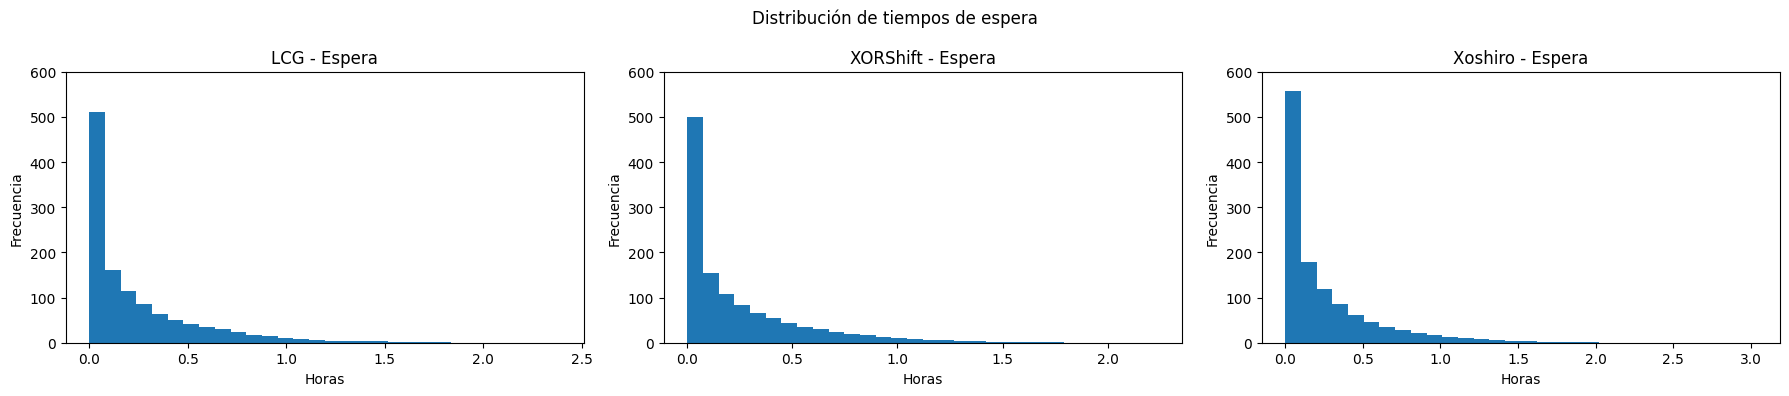

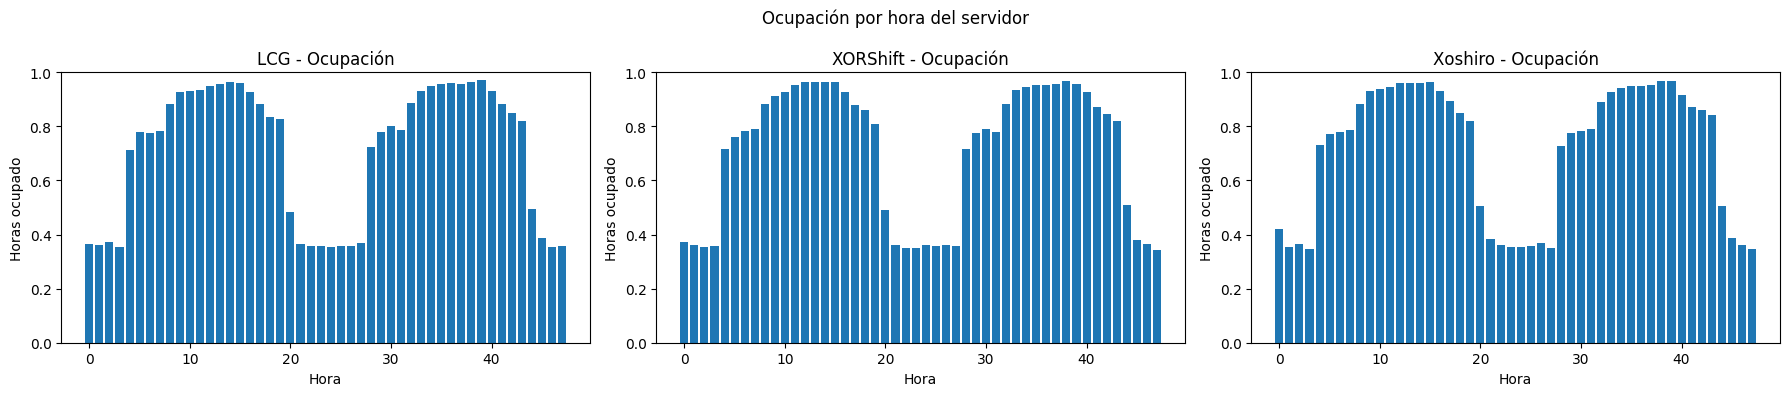

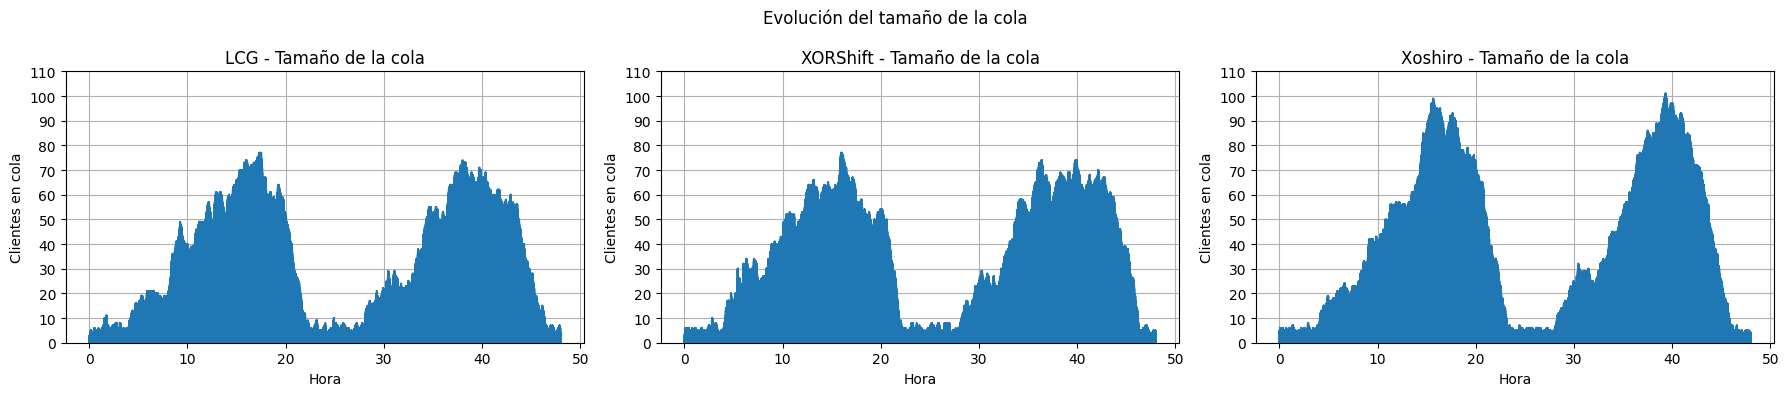

╒═════════════╤════════════════════╤═══════════════════╤══════════════════════╕
│ Generador   │   Prom. Espera (h) │   Utilización (%) │   Prom. Servicio (h) │
╞═════════════╪════════════════════╪═══════════════════╪══════════════════════╡
│ LCG         │               0.24 │             71.32 │               0.0286 │
├─────────────┼────────────────────┼───────────────────┼──────────────────────┤
│ XORShift    │               0.24 │             71.18 │               0.0285 │
├─────────────┼────────────────────┼───────────────────┼──────────────────────┤
│ Xoshiro     │               0.25 │             71.56 │               0.0286 │
╘═════════════╧════════════════════╧═══════════════════╧══════════════════════╛


In [33]:
comparar_generadores(resultados)
tabla_resumen(resultados)